Running simulation 1/200
Running simulation 2/200
Running simulation 3/200
Running simulation 4/200
Running simulation 5/200
Running simulation 6/200
Running simulation 7/200
Running simulation 8/200
Running simulation 9/200
Running simulation 10/200
Running simulation 11/200
Running simulation 12/200
Running simulation 13/200
Running simulation 14/200
Running simulation 15/200
Running simulation 16/200
Running simulation 17/200
Running simulation 18/200
Running simulation 19/200
Running simulation 20/200
Running simulation 21/200
Running simulation 22/200
Running simulation 23/200
Running simulation 24/200
Running simulation 25/200
Running simulation 26/200
Running simulation 27/200
Running simulation 28/200
Running simulation 29/200
Running simulation 30/200
Running simulation 31/200
Running simulation 32/200
Running simulation 33/200
Running simulation 34/200
Running simulation 35/200
Running simulation 36/200
Running simulation 37/200
Running simulation 38/200
Running simulation 39

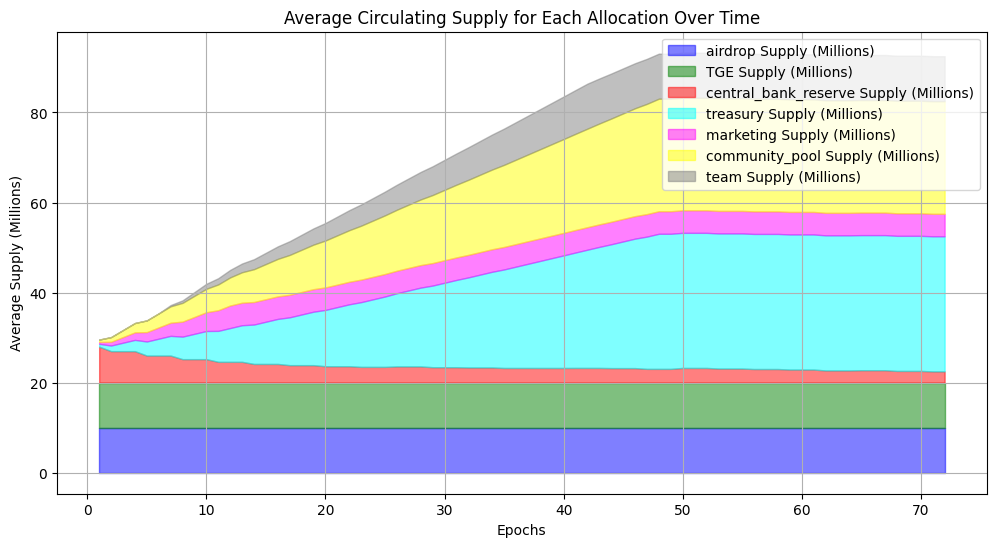

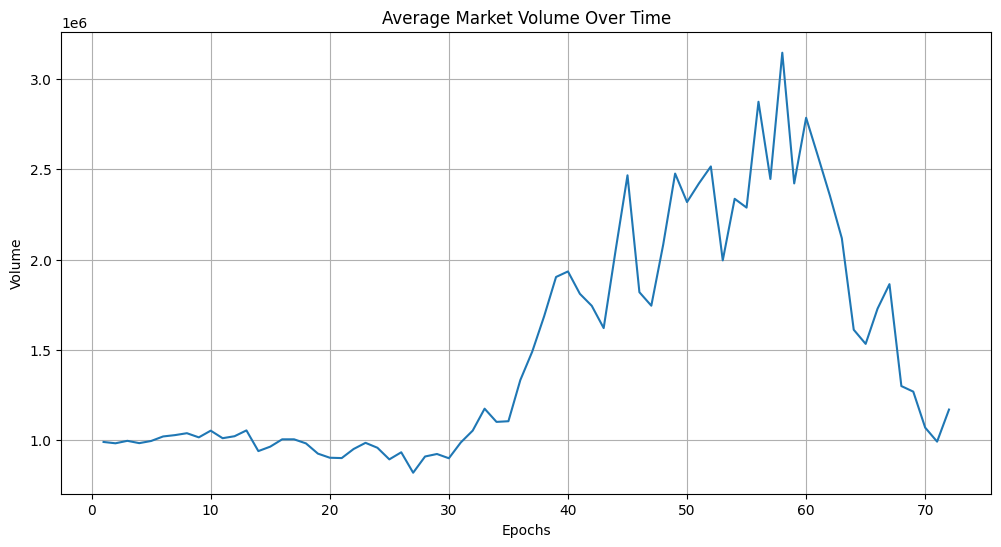

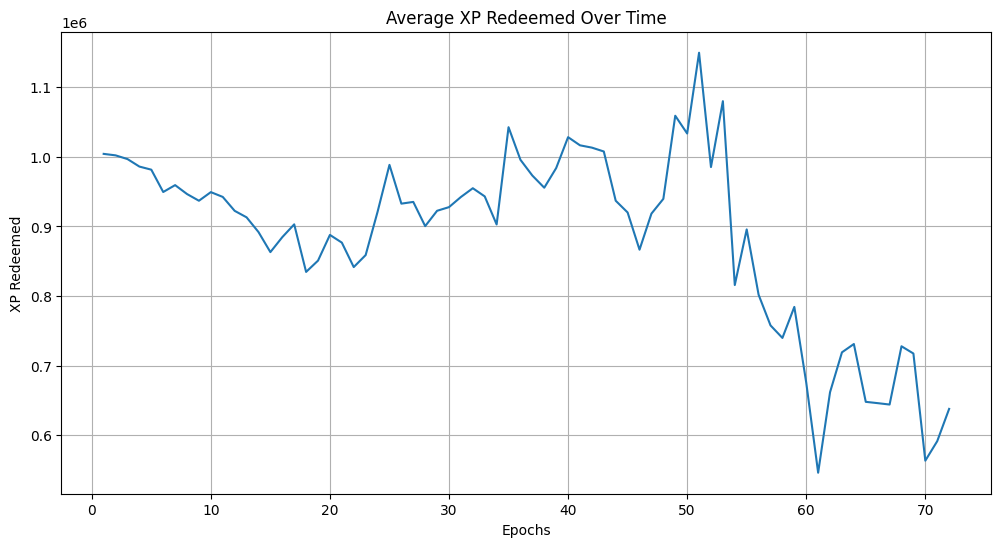

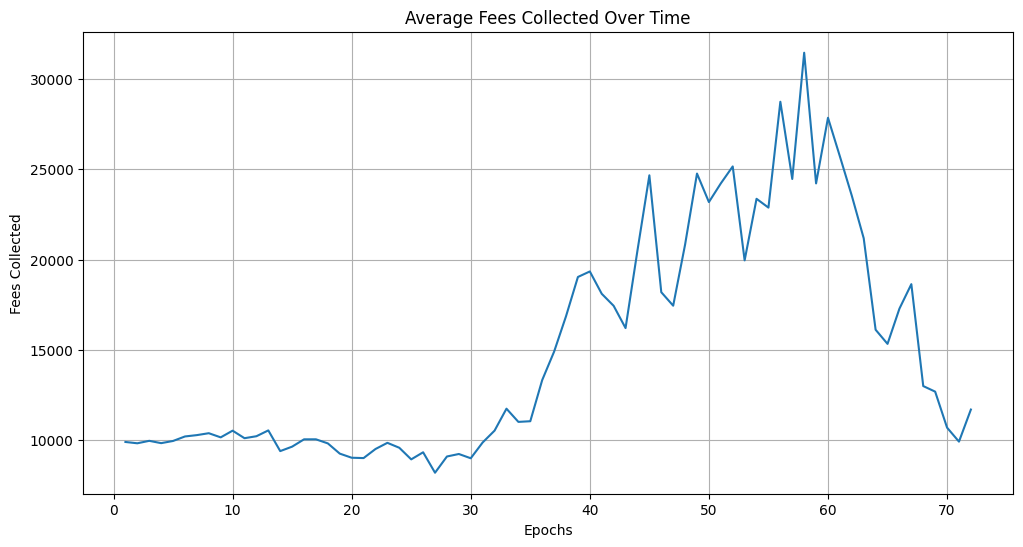

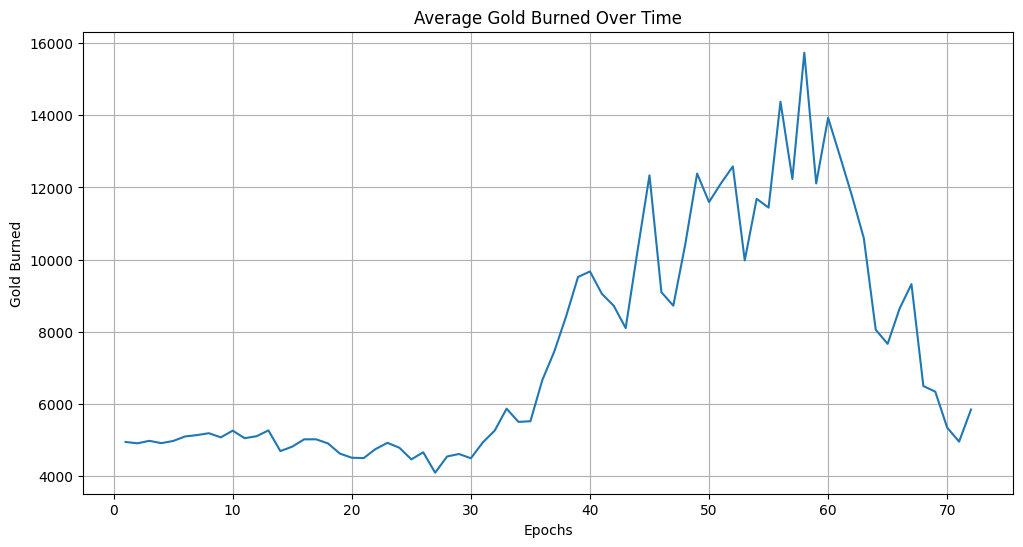

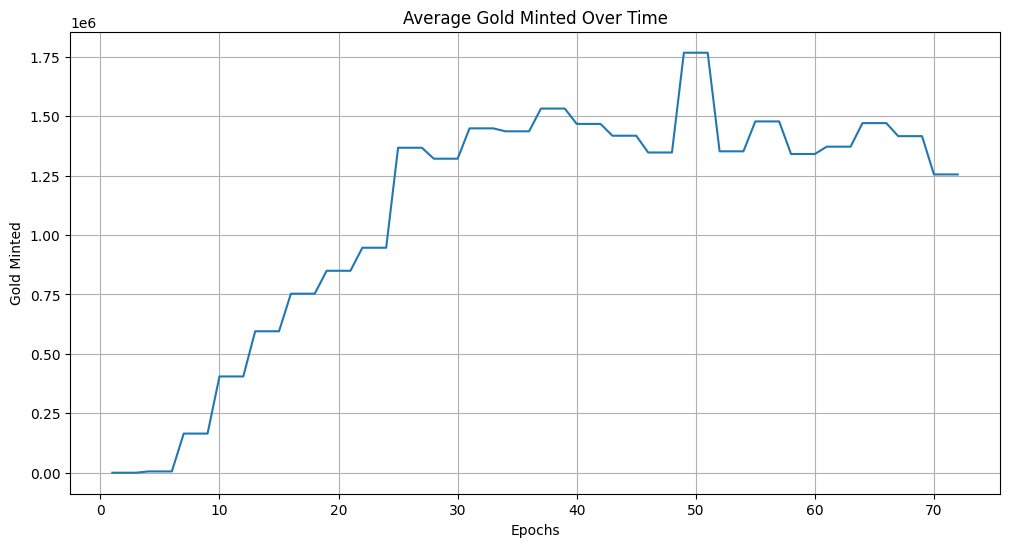

In [35]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import seaborn as sns

class GoldToken:
    def __init__(self, initial_supply):
        # Define initial allocations as percentages of the innitial supply
        # Only airdrop, TGE and Reserve are immediatelly unlocked
        self.allocations = {
            'airdrop': 0.1 * initial_supply,
            'TGE': 0.1 * initial_supply,
            'central_bank_reserve': 0.08 * initial_supply,
            'treasury': 0.3 * initial_supply,
            'marketing': 0.05 * initial_supply,
            'community_pool': 0.25 * initial_supply,
            'team': 0.1 * initial_supply,
            'Redeemed': 0
        }
        # Initially, only unlocked allocations are circulating
        self.total_supply = initial_supply
        self.circulating_supply = self.allocations['airdrop'] + self.allocations['TGE'] + self.allocations['central_bank_reserve']
        self.locked_supply = sum(self.allocations.values()) - self.circulating_supply

        # Define vesting schedules (in epochs)
        self.vesting_schedules = {
            'treasury': {'total_duration': 48, 'cliff': 0, 'release_per_epoch': (self.allocations['treasury']/48), 'circulating': 0},
            'marketing': {'total_duration': 12, 'cliff': 0, 'release_per_epoch': (self.allocations['marketing']/12), 'circulating': 0},
            'community_pool': {'total_duration': 48, 'cliff': 0, 'release_per_epoch': (self.allocations['community_pool']/48), 'circulating': 0},
            'team': {'total_duration': 36, 'cliff': 6, 'release_per_epoch': (self.allocations['team']/36), 'circulating': 0},
        }

        # Set circulating supply for vesting allocations to zero
        for allocation in self.vesting_schedules:
            self.allocations[allocation] = 0

    def mint(self, amount):
        self.total_supply += amount
        self.circulating_supply += amount

    #def burn(self, amount):
        #self.circulating_supply -= amount

    def update_vesting(self, epoch):
        for allocation, schedule in self.vesting_schedules.items():
            if epoch >= schedule['cliff']:
                if 'circulating' not in schedule:  # Initialize if not present
                    schedule['circulating'] = 0
                total_vested = schedule['release_per_epoch']
                if epoch <= (schedule['cliff'] + schedule['total_duration']):
                    schedule['circulating'] += total_vested
                    self.circulating_supply += total_vested
                    self.total_supply =+ total_vested
                    self.locked_supply -= total_vested
                    self.allocations[allocation] += total_vested
                # Ensure that we do not exceed the allocation after the vesting period
                self.allocations[allocation] = min(self.allocations[allocation], schedule['total_duration'] * schedule['release_per_epoch'])

    def get_total_supply(self):
        return self.total_supply

    def get_circulating_supply(self):
        return self.circulating_supply

    def get_burned(self):
        return self.burned

    def get_allocation(self, allocation_name):
        return self.allocations.get(allocation_name, 0)

class CentralBank:
    def __init__(self, gold_token, initial_rate, initial_supply):
        self.gold_token = gold_token
        self.inflation_rate = initial_rate
        self.reserve = gold_token.allocations['central_bank_reserve']
        self.decay_factor = 0.02083  # 25% inflation decay each year
        self.usd_reserve = 0 # USD reserve - from fees collected (can be used for buybacks)
        self.redemption_frequency = 3 # Redemptions happens after 3 weeks
        self.redemption_duration = 1 # Redemptions lasts for 1 week
        self.gold_minted_history = [] # Stores gold minted history


    def mint(self, amount):
        adjusted_amount = amount * (1 + self.inflation_rate) # Everytime we mint we add inflation on it
        self.gold_token.mint(adjusted_amount)
        self.reserve += adjusted_amount
        self.gold_token.allocations['central_bank_reserve'] += adjusted_amount  # Always mint to the reserve
        self.gold_minted_history.append(adjusted_amount)
        #print("Minted " + str(amount) + "GOLD for the Reserve")

    #def burn(self, amount):
        #self.gold_token.burn(amount) # The burn amount comes from market buy, the amount in USD is stored on gold_burned in market
        #print("Burned " + str(amount) + " USD in GOLD")

    def redeem_xp(self, xp_redeemed, current_epoch):
        # Check if redemption is enabled for the current epoch
        if current_epoch % self.redemption_frequency < self.redemption_duration:
            # Gold needed equals to the amount of xp_redeemed per epoch
            gold_needed = xp_redeemed

            if gold_needed > 0:
                if (self.reserve/gold_needed) < 2.5: # We only mint if our reserve/xp ratio is < 2.5
                  additional_gold = 2.5 * gold_needed - self.reserve
                  self.mint(additional_gold)
                  gold_used = gold_needed
                  self.reserve -= gold_needed
                  self.gold_token.allocations['central_bank_reserve'] -= gold_needed
                  self.gold_token.allocations['Redeemed'] += gold_needed

                  return gold_used, additional_gold

                else:
                  gold_used = gold_needed
                  self.reserve -= gold_needed
                  self.gold_token.allocations['central_bank_reserve'] -= gold_needed
                  self.gold_token.allocations['Redeemed'] += gold_needed
                  return gold_used

            else:
                # If gold_needed is zero, no action is required
                return 0, 0


    def update_inflation(self):
        self.inflation_rate *= self.decay_factor

    def get_reserve(self):
        return self.reserve

    def get_usd_reserve(self):
        return self.usd_reserve

    def get_inflation_rate(self):
        return self.inflation_rate

class Market:
    def __init__(self, fee_percentage, burning_rate, central_bank):
        self.fee_percentage = fee_percentage
        self.burning_rate = burning_rate
        self.central_bank = central_bank
        self.fees_collected = 0
        self.gold_burned_history = []  # Stores the amount of gold burned (in USD) each epoch
        self.fees_collected_history = []  # Stores the amount of fees collected (in USD) each epoch

    def simulate_epoch(self, central_bank, epoch_volume):
        self.fees_collected = epoch_volume * self.fee_percentage # Fees collected in USD
        gold_to_burn = self.fees_collected * self.burning_rate # GOLD to be burned in USD
        #self.central_bank.burn(gold_to_burn) # Burns the corresponding part of GOLD
        self.central_bank.usd_reserve +=  (self.fees_collected - gold_to_burn) # Adds part of fees to USD reserves
        self.gold_burned_history.append(gold_to_burn) # Append gold burned to the history

    def get_fees_collected(self):
        return self.fees_collected

def plot_results(epochs, circulating_supply_history, allocation_histories):
    plt.figure(figsize=(12, 6))

    # Ensure data lengths match
    if len(epochs) != len(circulating_supply_history):
        raise ValueError("Mismatch in length of epochs and circulating supply history")

    # Plot each allocation's circulating supply
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'grey', 'black']
    bottom = np.zeros(len(epochs))  # Initialize bottom for stacking
    for i, (allocation, history) in enumerate(allocation_histories.items()):
        if len(epochs) != len(history):
            raise ValueError(f"Mismatch in length of epochs and history for {allocation}")
        plt.fill_between(epochs, bottom, bottom + np.array(history), label=f'{allocation} Supply (Millions)', color=colors[i % len(colors)], alpha=0.5)
        bottom += np.array(history)  # Update bottom for next allocation

    # Plot the total circulating supply
    plt.plot(epochs, circulating_supply_history, label='Total Circulating Supply (Millions)', color='black', linewidth=2)

    plt.xlabel('Epochs (Months)')
    plt.ylabel('Gold (Millions)')
    plt.title('Gold Circulating Supply and Allocation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def xp_redeem_random_factor():
    # Normal distribution with mean = 1 and standard deviation = 0.3
    # This will center most values around 1, with some variability
    factor = random.normalvariate(1, 0.3)
    # Ensure the factor is within a reasonable range
    return max(0.4, min(factor, 2))


def volume_random_factor():
    # Normal distribution with mean = 1 and standard deviation = 0.3
    factor = random.normalvariate(1, 0.3)
    # Ensure the factor is within a reasonable range
    return max(0.4, min(factor, 2))

def main():
    # Initialize parameters
    initial_rate = 0.10  # 10% yearly inflation
    initial_supply = 100000000  # 100 million Gold initially
    xp_redeemed = 1000000 # 1M XP redeemed per month as base
    initial_volume = 1000000  # 100k USD volume per epoch
    fee_percentage = 0.01  # 1% fee (from in game transactions in USD) - 50% for the reserve, 50% burned
    burning_rate = 0.50  # 50% of fees burned per epoch (from in game transactions)

    # Initialize classes
    gold_token = GoldToken(initial_supply)
    central_bank = CentralBank(gold_token, initial_rate, initial_supply)
    market = Market(fee_percentage, burning_rate, central_bank)

    epochs = 72  # Number of epochs to simulate

    # Data for plotting
    circulating_supply_history = []
    total_supply_history = []
    allocation_histories = {name: [] for name in gold_token.allocations.keys()}

     # Lists to store metrics
    market_volume_history = []
    fees_collected_history = []
    gold_burned_history = [] # Part of the fees
    gold_minted_history = [] # Total GOLD minted
    xp_redeemed_history = [] # Total XP redeemed per epoch
    central_bank_usd_reserve_history = [] # Part of the fees

    for epoch in range(epochs):
        # Update vesting and circulating supply for the current epoch
        gold_token.update_vesting(epoch)

        # Update allocation histories for each allocation
        for name in allocation_histories.keys():
            current_allocation = gold_token.get_allocation(name) / 1e6  # Convert to millions
            allocation_histories[name].append(current_allocation)

        # Gets the random xp and volume
        xp_redeemed *= xp_redeem_random_factor()
        initial_volume *= volume_random_factor()

        # Simulate market activities for the current epoch
        market.simulate_epoch(central_bank, initial_volume)

        # Simulate XP redeem
        central_bank.redeem_xp(xp_redeemed, epoch)

        # Update the inflation rate for the next epoch
        central_bank.update_inflation()

        # Append the current circulating supply to the history
        circulating_supply_history.append(gold_token.get_circulating_supply() / 1e6) # Convert to millions
        total_supply_history.append(gold_token.get_total_supply() / 1e6) # Convert to millions

        # Store the xp_redeemed for the current epoch
        xp_redeemed_history.append(xp_redeemed)

        # Store market metrics for the current epoch
        market_volume_history.append(initial_volume)
        fees_collected_history.append(market.get_fees_collected())
        central_bank_usd_reserve_history.append(central_bank.get_usd_reserve())

         # Check if the list is empty before accessing
        if market.gold_burned_history:
            gold_burned_history.append(market.gold_burned_history[-1])
        else:
            gold_burned_history.append(0)  # Append 0 if the list is empty

        if central_bank.gold_minted_history:
            gold_minted_history.append(central_bank.gold_minted_history[-1])
        else:
            gold_minted_history.append(0)  # Append 0 if the list is empty


    # Plot the results
    # plot_results(range(epochs), circulating_supply_history, allocation_histories)

    # Create a DataFrame for the allocation histories and market metrics
    allocation_df = pd.DataFrame(allocation_histories, index=range(epochs))
    allocation_df['Total Supply'] = total_supply_history
    allocation_df['Total Circulating Supply'] = circulating_supply_history
    allocation_df['XP Redeemed'] = xp_redeemed_history
    allocation_df['Market Volume'] = market_volume_history
    allocation_df['Fees Collected'] = fees_collected_history
    allocation_df['Gold Burned'] = gold_burned_history
    allocation_df['Gold Minted'] = gold_minted_history
    allocation_df['Central Bank USD reserve'] = central_bank_usd_reserve_history
    allocation_df['Epoch'] = allocation_df.index + 1  # Add an 'Epoch' column


    # Print the DataFrame
    # print(allocation_df)

    # Return both the DataFrame and the final total supply
    return allocation_df

def run_simulations(num_simulations):
    all_results = []
    final_total_supplies = []

    for sim in range(num_simulations):
        print(f"Running simulation {sim + 1}/{num_simulations}")
        result = main()  # Run the simulation and get final total supply
        result['Simulation'] = sim + 1  # Add a column to identify the simulation
        all_results.append(result)

    # Combine all results into a single DataFrame
    combined_results = pd.concat(all_results)

    return combined_results


def analyze_results(combined_results):
    # Filter out the results where the total supply is equal to 100,000
    filtered_results = combined_results[combined_results['Total Circulating Supply'] != 100000000]

    # Calculate average circulating supply per epoch for each allocation
    avg_allocations = filtered_results.groupby('Epoch')[[allocation for allocation in allocations.keys()]].mean()

    # Plot the average circulating supply for each allocation
    plot_stacked_allocations(avg_allocations)

    # Plot average market volume over time
    plot_market_volume(filtered_results)

    # Plot additional metrics
    plot_metric_over_time(filtered_results, 'XP Redeemed', 'Average XP Redeemed Over Time')
    plot_metric_over_time(filtered_results, 'Fees Collected', 'Average Fees Collected Over Time')
    plot_metric_over_time(filtered_results, 'Gold Burned', 'Average Gold Burned Over Time')
    plot_metric_over_time(filtered_results, 'Gold Minted', 'Average Gold Minted Over Time')

def plot_stacked_allocations(avg_allocations):
    epochs = avg_allocations.index
    bottom = np.zeros(len(epochs))
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'grey', 'black']
    for i, allocation in enumerate(avg_allocations.columns):
        values = avg_allocations[allocation].values
        plt.fill_between(epochs, bottom, bottom + values, label=f'{allocation} Supply (Millions)', color=colors[i % len(colors)], alpha=0.5)
        bottom += values
    plt.title('Average Circulating Supply for Each Allocation Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Average Supply (Millions)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_market_volume(combined_results):
    avg_market_volume = combined_results.groupby('Epoch')['Market Volume'].mean()
    avg_market_volume.plot(figsize=(12, 6), title='Average Market Volume Over Time', xlabel='Epochs', ylabel='Volume')
    plt.grid(True)
    plt.show()

def plot_metric_over_time(combined_results, metric, title):
    avg_metric = combined_results.groupby('Epoch')[metric].mean()
    avg_metric.plot(figsize=(12, 6), title=title, xlabel='Epochs', ylabel=metric)
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    num_simulations = 200 # Number of simulations to run
    combined_results = run_simulations(num_simulations)
    analyze_results(combined_results)